In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ayoubgrm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayoubgrm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


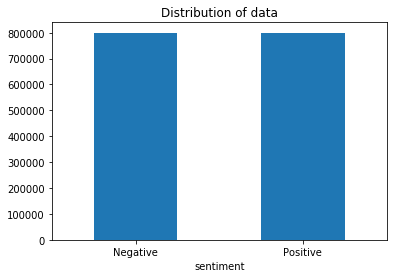

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])


In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', '>-)':
          'evilgrin', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', 
          ':-O': 'surprised', ':-*': 'kissing', ':-@': 'shocked', ':-$': 'confused',
          ':-\\': 'annoyed', ':-#': 'mute', '(((H)))': 'hugs', ':-X': 'kissing',
          '`:-)': 'smile', ':^)': 'smile', ':-&': 'confused', '<:-)': 'smile', 
          ':->': 'smile', '(-}{-)': 'kissing', ':-Q': 'smoking','$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':*)': 'smile',
          ':@': 'shocked',':-0': 'yell', ':-----)': 'liar', '%-(': 'confused',
          '(:I': 'egghead', '|-O': 'yawning', ':@)': 'smile', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', '~:0': 'baby', '-@--@-': 'eyeglass',
          ":'-)": 'sadsmile', '{:-)': 'smile', ';)': 'wink', ';-)': 'wink', 
          'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = set(stopwords.words('english'))

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    snowStem = SnowballStemmer("english")
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''           
        for word in tweet.split():            
            # Checking if the word is a stopword.
            if word not in stopwordlist:                
                if len(word)>1:    
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    # Stemming the word.
                    #word = snowStem.stem(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [5]:
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')

Text Preprocessing complete.


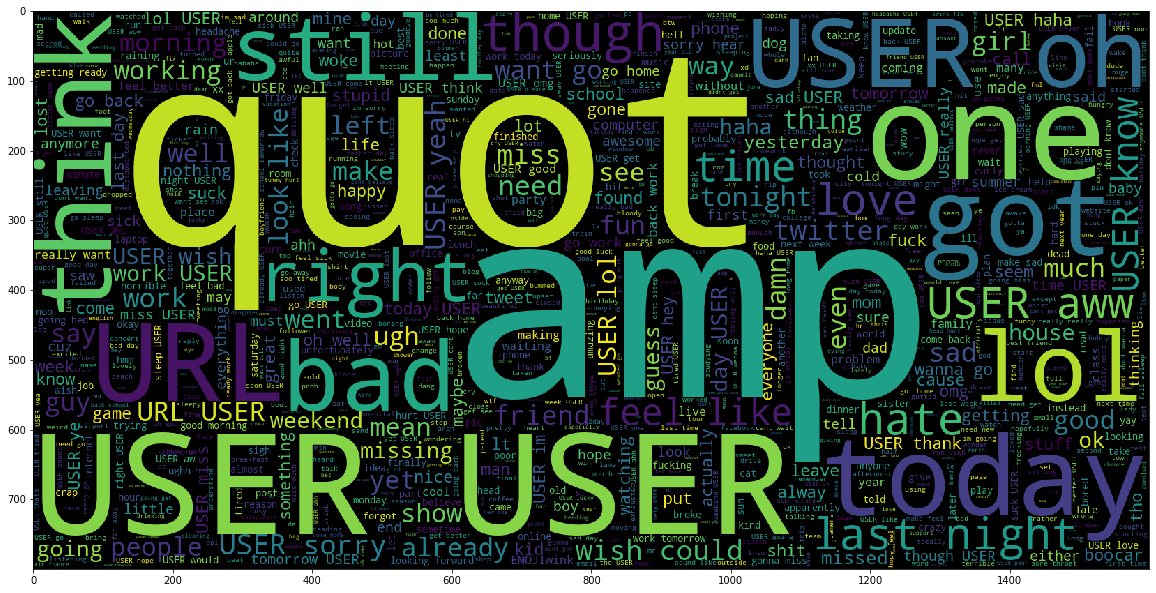

In [6]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_neg))
plt.imshow(wc)

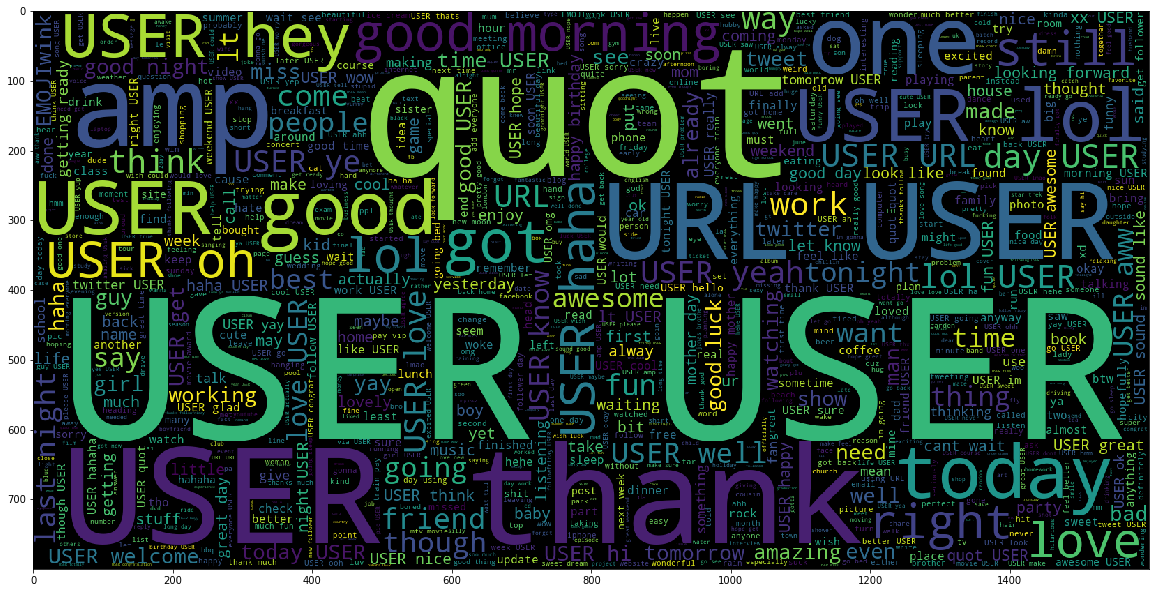

In [7]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [9]:
vectoriser = TfidfVectorizer(ngram_range=(1,2))
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  3941353


In [10]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [11]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Evaluate Accuracy for the model
    accuracy = accuracy_score(y_test, y_pred)*100
    print('Model accuracy: ', accuracy)
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Model accuracy:  78.5725


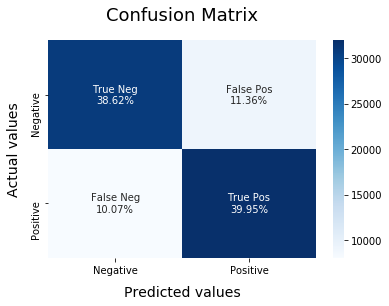

In [12]:
BNBmodel = BernoulliNB(alpha = 2.9)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

Model accuracy:  79.07499999999999


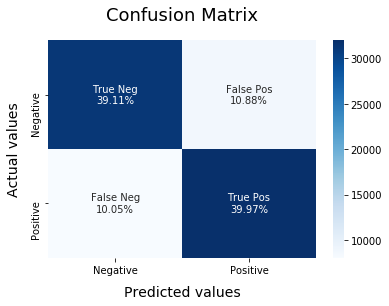

In [13]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Model accuracy:  79.9275


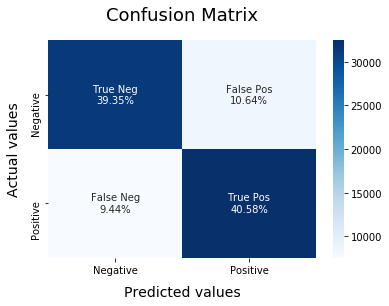

In [14]:
LRmodel = LogisticRegression(C = 1.9, max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [15]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LRv1.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [16]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "I like this notebook"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                   text sentiment
0        I hate twitter  Negative
1  I like this notebook  Positive
